# Melanoma Detection Assignment

Building a CNN based model which can accurately detect **melanoma**. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## I. Data understanding

In [1]:
# Importing required libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

tf.get_logger().setLevel('ERROR')


# Create a function to append the full path to the folder
def get_full_path(path):
  ## Folder in google drive
  base_path = 'dataset'
  return os.path.join(base_path, path)


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(get_full_path('Train'))
data_dir_test = pathlib.Path(get_full_path('Test'))

In [3]:
# Print the size of train and test data
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## II. Data preprocessing & visualization

### Create a dataset
Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
# create train dataset
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    get_full_path('Train'),
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(img_width, img_height),
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.


In [6]:
# List out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualize Data
Visualize one instance of all the nine classes present in the dataset

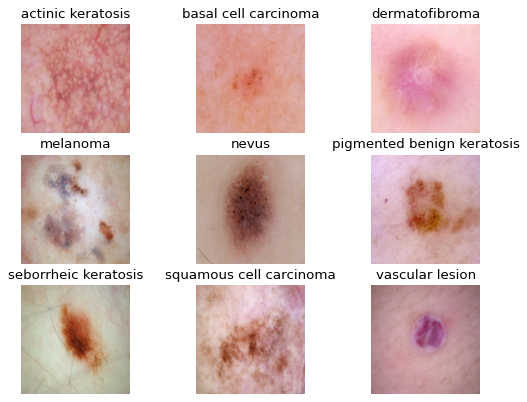

In [7]:
from matplotlib.pyplot import figure
import matplotlib.image as mpimg

# Setting the plot size
figure(figsize=(8, 6), dpi=80)

# Find the element with the selected label
def find_sample_with_label_in_batch_dataset(dataset, to_find_label):
  for images, labels in dataset:
    for i, label in enumerate(labels):
      if label == to_find_label: 
        return images[i], label;

for i, class_name in enumerate(class_names):
  image, label = find_sample_with_label_in_batch_dataset(train_ds, i);
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image.numpy().astype("uint8"))
  plt.title(class_name)
  plt.axis('off')

### Prefetching Data to Optimize Performance
`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## III. Model Building

In [9]:
# Create an utility to visualize the result
def visualize_model_result(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [10]:
from tensorflow.keras.regularizers import l2

input_shape = (img_height, img_width, 3);
# model
model = Sequential()

model.add(layers.Rescaling(scale=1./255, input_shape=input_shape))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

# flatten and put a fully connected layer
model.add(layers.Flatten())
model.add(layers.Dense(512, kernel_regularizer=l2(0.01)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

# softmax layer
model.add(layers.Dense(len(class_names), activation='softmax'))

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 178, 178, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0

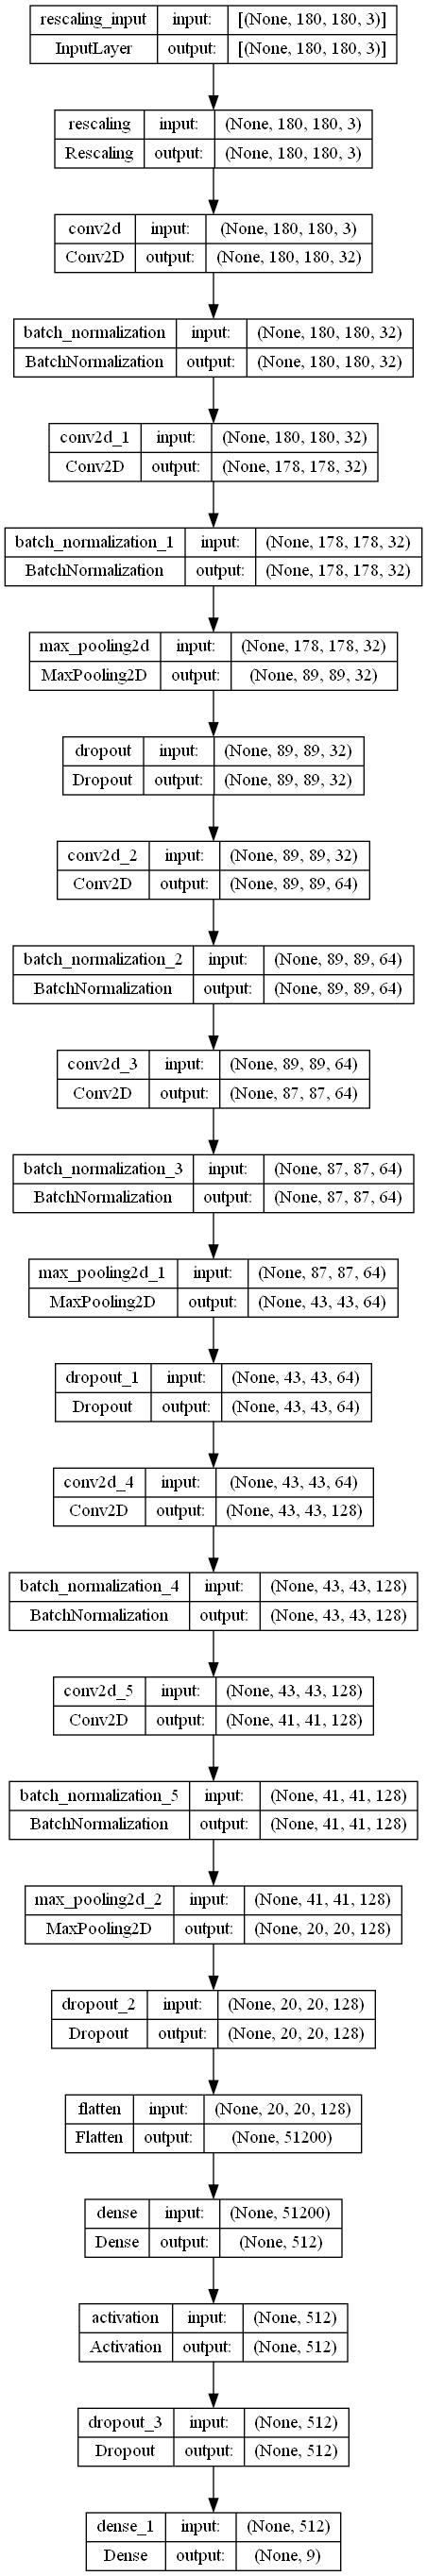

In [11]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [12]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 10s 104ms/step - loss: 14.3054 - accuracy: 0.2935 - val_loss: 12.5139 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 5s 94ms/step - loss: 11.6051 - accuracy: 0.4007 - val_loss: 13.1207 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 5s 94ms/step - loss: 11.2153 - accuracy: 0.4559 - val_loss: 14.1093 - val_accuracy: 0.1544
Epoch 4/20
56/56 [==============================] - 5s 94ms/step - loss: 10.8816 - accuracy: 0.4939 - val_loss: 14.2009 - val_accuracy: 0.1767
Epoch 5/20
56/56 [==============================] - 5s 95ms/step - loss: 10.5599 - accuracy: 0.5485 - val_loss: 15.1966 - val_accuracy: 0.1924
Epoch 6/20
56/56 [==============================] - 5s 94ms/step - loss: 10.2395 - accuracy: 0.5854 - val_loss: 12.2774 - val_accuracy: 0.3177
Epoch 7/20
56/56 [==============================] - 5s 95ms/step - loss: 9.9238 - accuracy: 0.6183 - val_loss: 12.6426 - val_accuracy: 0.286

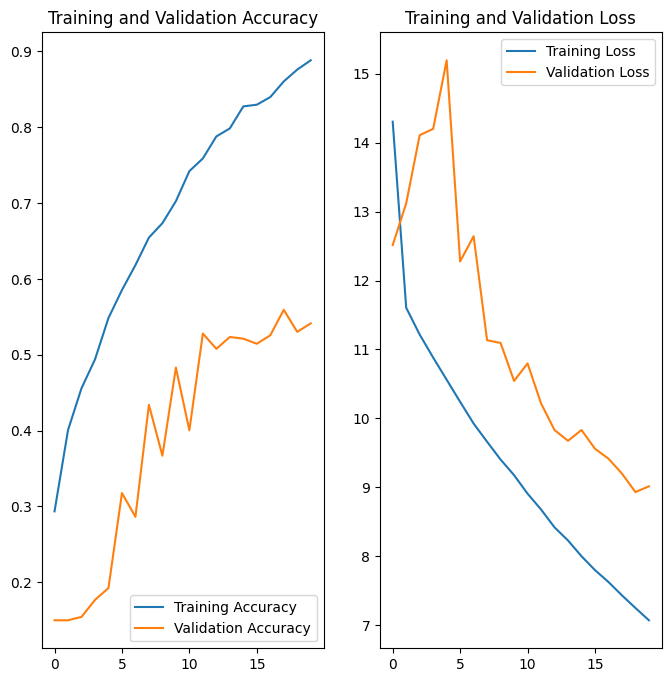

In [13]:
visualize_model_result(history)

**Insight:**
- The training accuracy is 87% validation accuracy is just around 52%
- The model seems to overfit as there is a huge gap between training and validation accuracy

### Rebuilding the model with some augementation strategies
Let's use some data augumentation strategy from tensorflow to preprocessing image
- RandomFlip
- RandomRotation
- RandomZoom

In [14]:
augmentation_layers = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

Visualize the sample image after augumenting

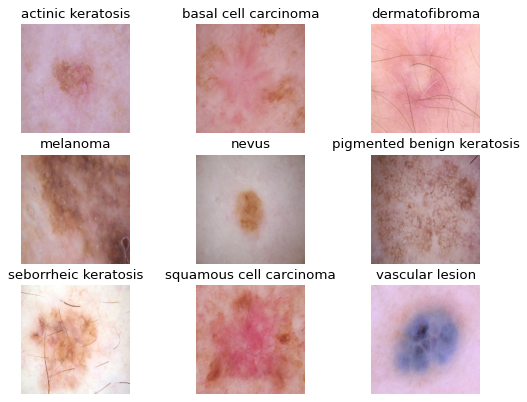

In [15]:
# Setting the plot size
figure(figsize=(8, 6), dpi=80)

# Find the element with the selected label
def find_sample_with_label_in_batch_dataset(dataset, to_find_label):
  for images, labels in dataset:
    for i, label in enumerate(labels):
      if label == to_find_label: 
        # Augment image
        return augmentation_layers(images)[i], label;

for i, class_name in enumerate(class_names):
  image, label = find_sample_with_label_in_batch_dataset(train_ds, i);
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image.numpy().astype("uint8"))
  plt.title(class_name)
  plt.axis('off')

Rebuild the model

In [16]:
model = Sequential()

# Add augmented layers
model.add(augmentation_layers)
model.add(layers.Rescaling(scale=1./255, input_shape=input_shape))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

# flatten and put a fully connected layer
model.add(layers.Flatten())
model.add(layers.Dense(512, kernel_regularizer=l2(0.01)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

# softmax layer
model.add(layers.Dense(len(class_names), activation='softmax'))

# model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 batch_normalization_7 (Batc  (None, 178, 178, 32)     128       
 hNormalization)                                      

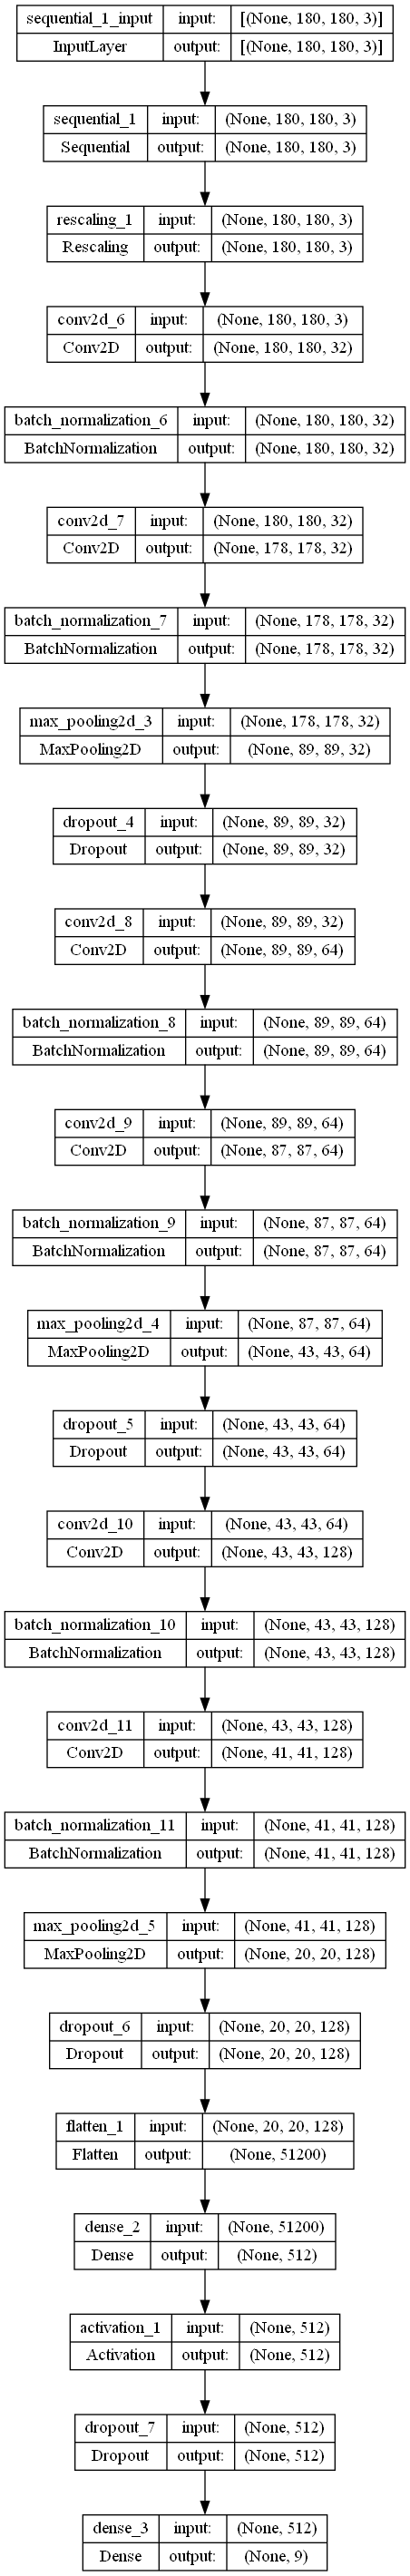

In [17]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [18]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 16s 241ms/step - loss: 14.6102 - accuracy: 0.3203 - val_loss: 12.7135 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 13s 239ms/step - loss: 11.5851 - accuracy: 0.4241 - val_loss: 14.7033 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 13s 238ms/step - loss: 11.1923 - accuracy: 0.4833 - val_loss: 13.3445 - val_accuracy: 0.2282
Epoch 4/20
56/56 [==============================] - 13s 239ms/step - loss: 10.9506 - accuracy: 0.4738 - val_loss: 16.3535 - val_accuracy: 0.1566
Epoch 5/20
56/56 [==============================] - 13s 239ms/step - loss: 10.7137 - accuracy: 0.4927 - val_loss: 13.2887 - val_accuracy: 0.1834
Epoch 6/20
56/56 [==============================] - 13s 238ms/step - loss: 10.4178 - accuracy: 0.5279 - val_loss: 12.5906 - val_accuracy: 0.3244
Epoch 7/20
56/56 [==============================] - 13s 238ms/step - loss: 10.2215 - accuracy: 0.5279 - val_loss: 13.2619 - val_ac

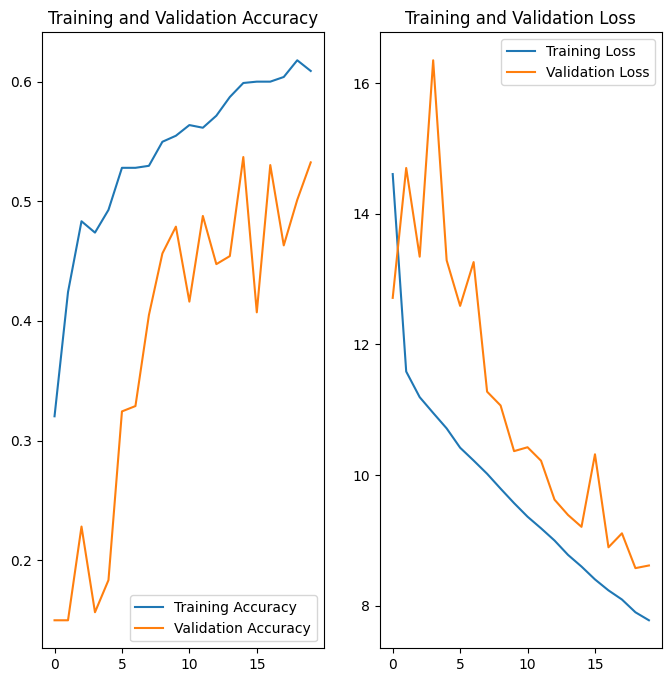

In [19]:
visualize_model_result(history)

**Insight:**
- The second model is not much better than the first one regarding the training accuracy
- However, the overfitting problem is resolved slightly due to data augementation

### Find the distribution of classes in the training dataset.
**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [20]:
# Create a dataframe with class name and count of image in that class
df = pd.DataFrame({ 'class_name': [], 'count': [] })

for class_name in class_names:
  df_temp = pd.DataFrame({ 'class_name': [class_name], 'count': [len(os.listdir(get_full_path(f'Train/{class_name}')))] })
  df = pd.concat([df, df_temp], ignore_index=True)

df.head(10)

,class_name,count
0,actinic keratosis,114.0
1,basal cell carcinoma,376.0
2,dermatofibroma,95.0
3,melanoma,438.0
4,nevus,357.0
5,pigmented benign keratosis,462.0
6,seborrheic keratosis,77.0
7,squamous cell carcinoma,181.0
8,vascular lesion,139.0


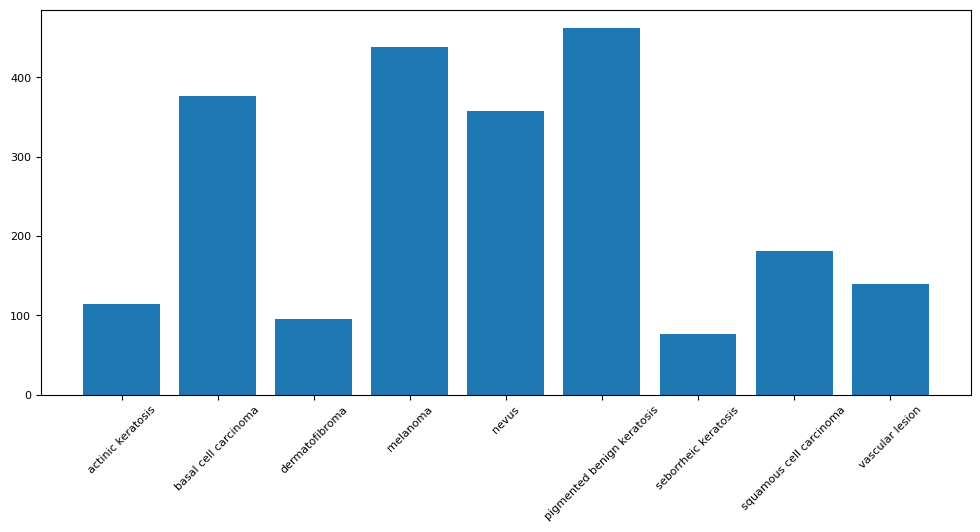

In [21]:
# Plot a bar chart to visualize
plt.rc('font', size=8)
plt.figure(figsize=(12,5))
plt.bar(df['class_name'], df['count'])
plt.xticks(rotation=45)
plt.show()

**Insight:**
- `seborrheic keratosis` has the least number of samples (77)
- `pigmented benigh keratosis ` has the most number of samples (462)

We can see the imbalance in class distribution of the dataset

### Rectify the class imbalance
We can use a python package known as Augmentor to add more samples across all classes so that none of the classes have very few samples.

In [22]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(get_full_path('Train'),save_format='jpg', output_directory='Train_Augmented')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to Downloads/dataset\Train\Train_Augmented.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20E69BABA00>: 100%|█| 500/500 [00:03<00:00, 140.41 Samples


Initialised with 2239 image(s) found.
Output directory set to Downloads/dataset\Train\Train_Augmented.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x20C1F3A5B70>: 100%|█| 500/500 [00:02<00:


Initialised with 2239 image(s) found.
Output directory set to Downloads/dataset\Train\Train_Augmented.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20C193B39A0>: 100%|█| 500/500 [00:03<00:00, 143.60 Samples


Initialised with 2239 image(s) found.
Output directory set to Downloads/dataset\Train\Train_Augmented.

Processing <PIL.Image.Image image mode=RGB size=2592x1944 at 0x20E6D970C40>: 100%|█| 500/500 [00:03<00:00, 166.11 Sampl


Initialised with 2239 image(s) found.
Output directory set to Downloads/dataset\Train\Train_Augmented.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20C0E756FB0>: 100%|█| 500/500 [00:03<00:00, 142.13 Samples


Initialised with 2239 image(s) found.
Output directory set to Downloads/dataset\Train\Train_Augmented.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20E6DBA62C0>: 100%|█| 500/500 [00:03<00:00, 154.75 Samples


Initialised with 2239 image(s) found.
Output directory set to Downloads/dataset\Train\Train_Augmented.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20C249C1B70>: 100%|█| 500/500 [00:03<00:00, 141.28 Samples


Initialised with 2239 image(s) found.
Output directory set to Downloads/dataset\Train\Train_Augmented.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20C1946D120>: 100%|█| 500/500 [00:03<00:00, 142.13 Samples


Initialised with 2239 image(s) found.
Output directory set to Downloads/dataset\Train\Train_Augmented.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20C1F3A73A0>: 100%|█| 500/500 [00:03<00:00, 128.30 Samples


In [23]:
# Move the Train_Augmented to the same level with Train folder
import shutil
shutil.move(get_full_path('Train/Train_Augmented'), get_full_path(''))

'Downloads/dataset\\Train_Augmented'

Augmentor has stored the augmented images in the `Train_Augmented` folder. Lets take a look at total count of augmented images.

In [24]:
# Counting the number of sample
data_dir_train_augmented = pathlib.Path(get_full_path('Train_Augmented'))
image_count_train = len(list(data_dir_train_augmented.glob('*/*.jpg')))
print(image_count_train)

4500


In [25]:
# Create a dataframe with class name and count of image in that class for the new augmented data
df = pd.DataFrame({ 'class_name': [], 'count': [] })

for class_name in class_names:
  df_temp = pd.DataFrame({ 'class_name': [class_name], 'count': [len(os.listdir(get_full_path(f'Train_Augmented/{class_name}')))] })
  df = pd.concat([df, df_temp], ignore_index=True)

df.head(10)

,class_name,count
0,actinic keratosis,221.0
1,basal cell carcinoma,742.0
2,dermatofibroma,197.0
3,melanoma,833.0
4,nevus,721.0
5,pigmented benign keratosis,931.0
6,seborrheic keratosis,150.0
7,squamous cell carcinoma,409.0
8,vascular lesion,296.0


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [26]:
# create new train and val dataset
train_ds_aug, val_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
    get_full_path('Train_Augmented'),
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(img_width, img_height),
    batch_size=batch_size,
)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.
Using 900 files for validation.


### Create, compile and train the model
We will use the same model as **Model 1** and observe the result

In [27]:
from tensorflow.keras.regularizers import l2

input_shape = (img_height, img_width, 3);
# model
model = Sequential()

model.add(layers.Rescaling(scale=1./255, input_shape=input_shape))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

# flatten and put a fully connected layer
model.add(layers.Flatten())
model.add(layers.Dense(512, kernel_regularizer=l2(0.01)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

# softmax layer
model.add(layers.Dense(len(class_names), activation='softmax'))

# model summary
model.summary()

# Compile and train model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

epochs = 50
history = model.fit(train_ds_aug, validation_data=val_ds_aug, epochs=epochs)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_12 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 batch_normalization_13 (Bat  (None, 178, 178, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)      

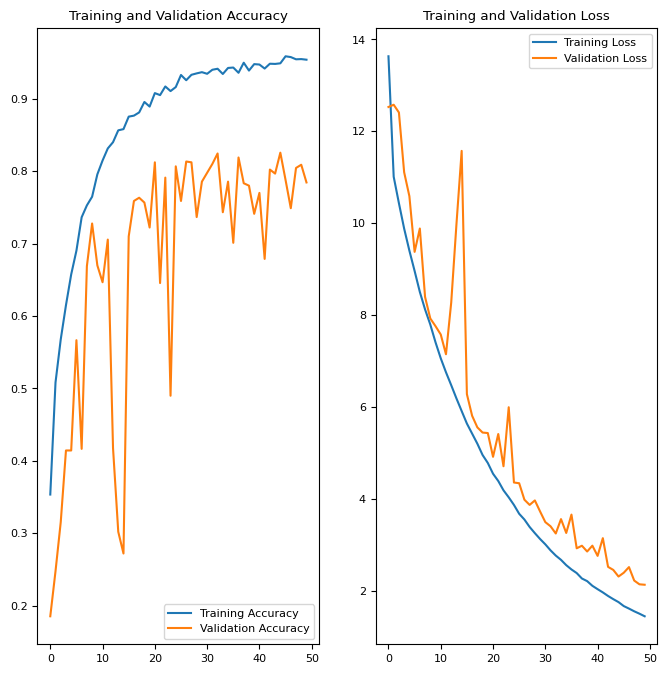

In [28]:
visualize_model_result(history)

**Insight:**
- After 20 epochs, the training accuracy is 89% and validation accuracy is 72%, which is better than the first model
- After 50 epochs the training accuracy is 95% and validation accuracy is 78%, the model is still quite overfitting